In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library("clustree")

Loading required package: ggraph

Loading required package: ggplot2



In [3]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [4]:
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [5]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [6]:
load(file="0711-ob.integratve-7samples.Rda")

In [7]:
allPC4<-ob.integrated

In [8]:
library(slingshot)
library(tidyverse)
library(Seurat)
library(scales)
library(viridis)
library(Matrix)

Loading required package: princurve

Warning message:
“multiple methods tables found for ‘which’”
Warning message:
“multiple methods tables found for ‘which’”
Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ plotly::filter() masks dplyr::filter(), stats::filter()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:re

In [9]:
library('SingleCellExperiment')

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Re

In [10]:
mat_filtered  <- as(as.matrix(allPC4@assays$integrated@data), 'sparseMatrix') 

In [11]:
annot<-list(cell.names=colnames(mat_filtered),clusters=allPC4@meta.data$seurat_clusters,orig.ident=allPC4@meta.data$orig.ident)

In [12]:
sds <- slingshot(Embeddings(allPC4, "umap"), clusterLabels = allPC4$seurat_clusters,start.clus = 6)

Using full covariance matrix



In [13]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

In [14]:
cell_colors_clust <- cell_pal(allPC4$seurat_clusters, hue_pal())

In [29]:
options(repr.plot.height=6,repr.plot.width=5)

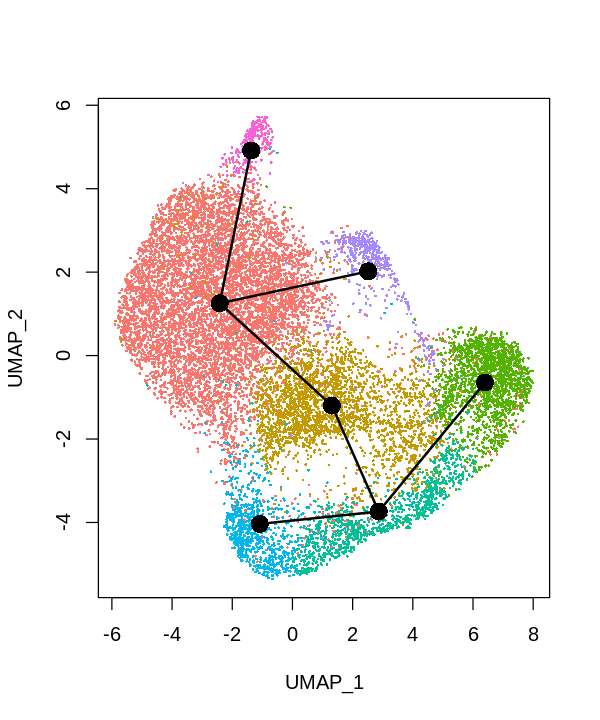

In [30]:
plot(reducedDim(sds), col = cell_colors_clust, pch = 16, cex = 0.3)
lines(sds, lwd = 2, type = 'lineages', col = 'black')

In [31]:
pdf('fig.2.6.pdf',width=5,height=6)
plot(reducedDim(sds), col = cell_colors_clust, pch = 16, cex = 0.3)
lines(sds, lwd = 2, type = 'lineages', col = 'black')
dev.off()

png 
  2

In [32]:
sds

class: SlingshotDataSet 

 Samples Dimensions
   14081          2

lineages: 3 
Lineage1: 6  0  1  3  2  
Lineage2: 6  0  1  3  4  
Lineage3: 6  0  5  

curves: 3 
Curve1: Length: 17.888	Samples: 9985.5
Curve2: Length: 14.23	Samples: 8478.43
Curve3: Length: 17.487	Samples: 8127.62

In [37]:
options(repr.plot.height=5,repr.plot.width=13)

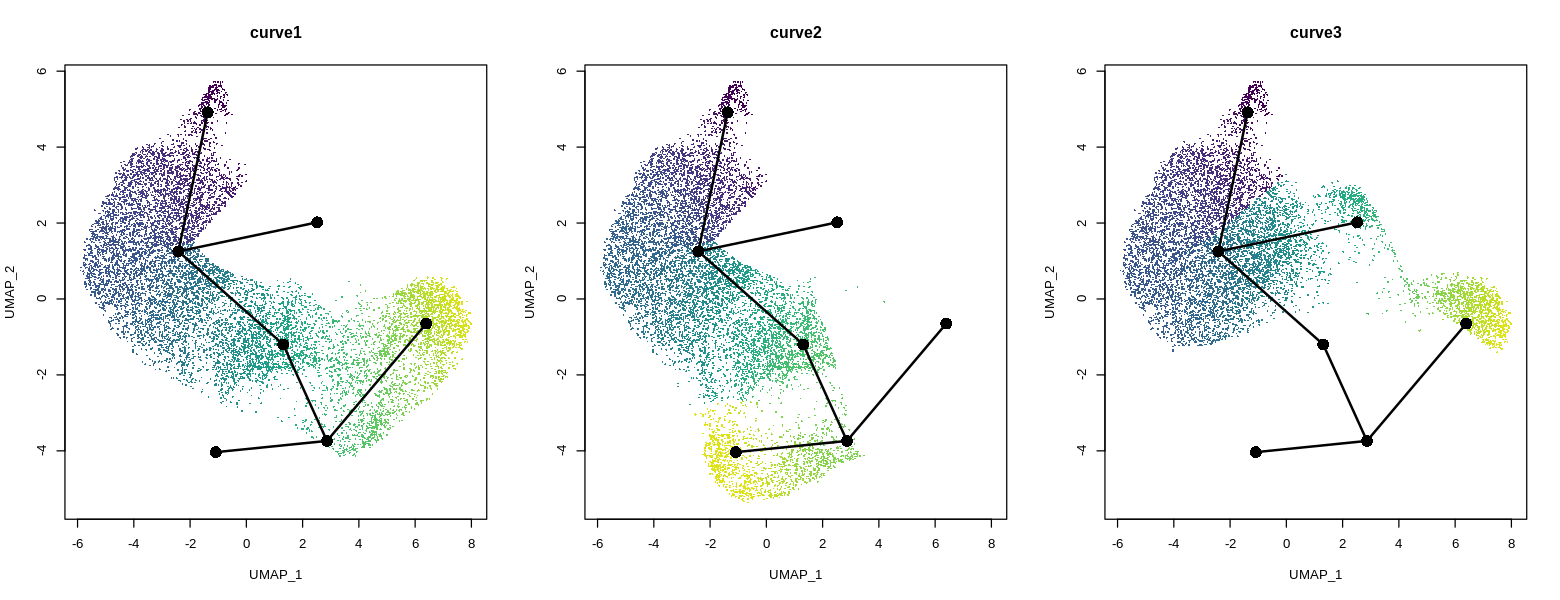

In [38]:
nc <- 3
pt <- slingPseudotime(sds)
nms <- colnames(pt)
nr <- ceiling(length(nms)/nc)
pal <- viridis(100, end = 0.95)
par(mfrow = c(nr, nc))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sds), col = colors, pch = 16, cex = 0.3, main = i)
  lines(sds, lwd = 2, col = 'black', type = 'lineages')
}

In [39]:
pdf('fig.2.7.pdf',width=13,height=5)
nc <- 3
pt <- slingPseudotime(sds)
nms <- colnames(pt)
nr <- ceiling(length(nms)/nc)
pal <- viridis(100, end = 0.95)
par(mfrow = c(nr, nc))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sds), col = colors, pch = 16, cex = 0.3, main = i)
  lines(sds, lwd = 2, col = 'black', type = 'lineages')
}
dev.off()

png 
  2